In [220]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_losses_3_2, plt_recons_with_dist, plt_sigma_as_func_of_alpha_and_c, plot_kernels, slide_kernel_over_signal, change_fig_size
from src.plotting.VAE_plotting import *

# import make_axes_locatable
import numpy as np
import dill
import io

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()


suptitle_size = 12
# Normal font weight
suptitle_fontweight = 'normal'
# suptitle_fontweight = 'bold'

rcparam = {'axes.labelsize': 4,
            'font.size': 6,
            'legend.fontsize': 6,
            'axes.titlesize': 10,
            'xtick.labelsize': 6,
            'ytick.labelsize': 6,
            # marker size 
            'lines.markersize': 4
            }
plt.rcParams.update(**rcparam)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_3620\2808072976.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [112]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [13]:
model_name = "curious-deluge-703"
# model_name = "radiant-sponge-688"
autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_3_VAE_voigt_decoder_CNN")

In [14]:
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(generator_num)
dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

loss = []
loss_mu = []

for i in range(10):
    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    x = x.cpu().detach().numpy()
    x_hat = x_hat.cpu().detach().numpy()
    x_hat_mu = x_hat_mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    z = z.cpu().detach().numpy()


    loss.append(np.mean((x - x_hat)**2, axis=1).mean())
    loss_mu.append(np.mean((x - x_hat_mu)**2, axis=1).mean())

print(np.mean(loss))
print(np.mean(loss_mu))

0.32052332
0.3196731


[0.0042275  0.00036911 0.00052485 0.00106505 0.00046504 0.00059821]


<Figure size 800x550 with 0 Axes>

<Figure size 551.181x404.199 with 0 Axes>

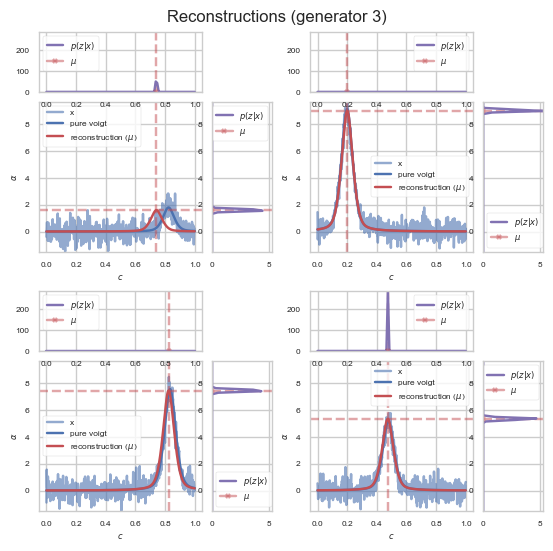

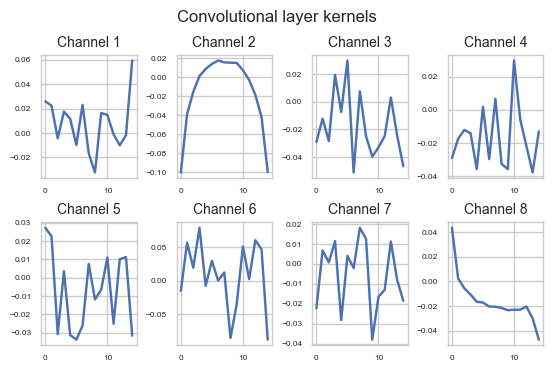

<Figure size 551.181x367.454 with 0 Axes>

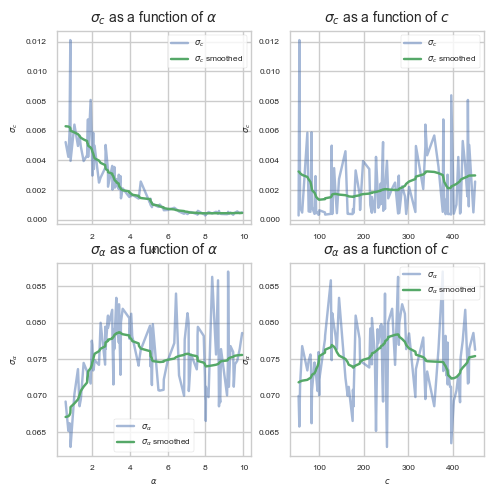

In [10]:
plot =  plot_losses_3_2(train_loss, 3, width_in_cm=14.5)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_losses"), ["pdf", "png"])

# print first 6 sigmas
print(sigma[:6,0])
# x, x_hat_mu, mu, sigma, y, generator_num, w, h
plot = plt_recons_with_dist(x, x_hat_mu, mu, sigma, y, 3, 2, 2, width_in_cm=14.5)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_reconstructions"), ["pdf", "png"])

plot = plot_kernels(autoencoder, layer_num=0, width_in_cm=14.5)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_kernels"), ["pdf", "png"])

plot = slide_kernel_over_signal(autoencoder, x[0], layer_num=0, width_in_cm=14.5)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_kernel_on_signal"), ["pdf", "png"])

plot = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y, width_in_cm=10)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_sigmaf"), ["pdf", "png"])


In [235]:
import wandb
api = wandb.Api()

# two plots side by side 
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
fig = change_fig_size(fig, 24.5)


ax = axs[0]

# Get CNN runs from wandb
filter_dict = {"tags":  "CNN_encoder_1"}
runs = api.runs("andreaslf/amortized-inference-for-spectroscopy", filters=filter_dict)

finished_runs = [run for run in runs if run.state == "finished"]
model_names = [run.name for run in finished_runs]
num_models = len(model_names)
losses = [run.summary["loss"] for run in finished_runs]
colors = {losses[i]: plt.cm.viridis(losses[i]/max(losses)) for i in range(len(losses))}

for i, model_name in enumerate(model_names):
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_3_VAE_voigt_decoder_CNN")

    # # plot mse 
    losses = train_loss["loss"]
    # line thicknes 0.5
    
    lab = f'ks: {finished_runs[i].config["kernel_sizes"]}, oc: {runs[i].config["out_channels"]}'

    loss = finished_runs[i].summary["loss"]


    ax.plot(losses, linewidth=1, label=lab, c = colors[loss])

ax.legend(frameon=True)
# ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")


ax = axs[1]

import pandas as pd 
import seaborn as sns
out_channels = list({run.config["out_channels"] for run in runs})
kernel_sizes = list({run.config["kernel_sizes"] for run in runs})

# Make matrix with out_channels and kernel_sizes as columns and rows
# and MSE as values
df = pd.DataFrame(columns=list(out_channels), index=list(kernel_sizes))

for run in runs:
    out_channel = run.config["out_channels"]
    kernel_size = run.config["kernel_sizes"]
    mse = run.summary["loss"]
    # mse = train_loss["MSE"][-1]
    df.loc[kernel_size, out_channel] = mse


# replace nan with max value
df = df.fillna(df.max().min())

# confusion matrix if nan value is present make it an x, colorbar label 
sns.heatmap(df, annot=True, fmt=".2f", linewidths=.5, cmap="viridis", cbar_kws={'label': 'Loss ($-\\mathcal{L}$)'})


ax.set_ylabel("Kernel size")
ax.set_xlabel("Out channels")
# subtitle 
# ax.set_title("Loss values")

# set plot title
plt.suptitle("Loss for different CNN hyperparameters", fontsize=suptitle_size, fontweight=suptitle_fontweight)
plt.tight_layout()

save_plot(plt, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_hyperparams"), ["pdf", "png"])
